# Prophet
### Note: Prophet has to be trained per store and item combination, meaning 500 models for all 10 stores and 50 items.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path

root_path = '../input/demand-forecasting-kernels-only/'
train_original = pd.read_csv(Path(root_path, 'train.csv'), low_memory=False, 
                    parse_dates=['date'], index_col=['date'])
test_original = pd.read_csv(Path(root_path, 'test.csv'), low_memory=False, 
                   parse_dates=['date'], index_col=['date'])
sample_sub_original = pd.read_csv(Path(root_path, 'sample_submission.csv'))

In [2]:
from fbprophet import Prophet

df1 = train_original.copy().reset_index()

df1.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Running the code below with Prophet's default settings gives us a a Public Score of around 19.4. We can tweak a few parameters:
- Prophet fits `yearly_seasonality` and `weekly_seasonality` by default, we can add in `daily_seasonality`
- Add in US holidays (assumes the stores are modelled after US stores)

  0%|          | 0/500 [00:00<?, ?it/s]

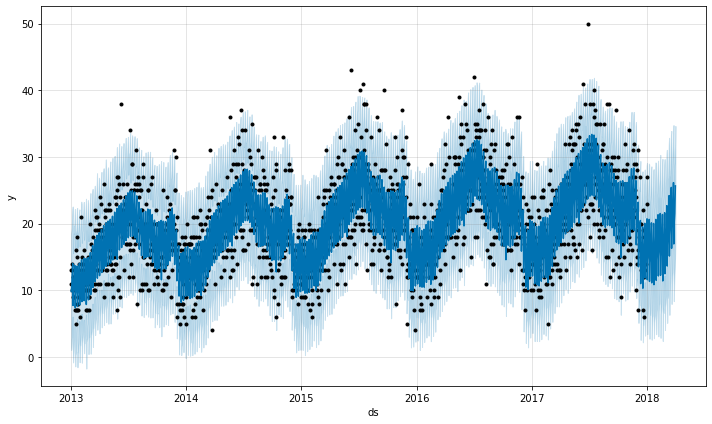

In [3]:
from tqdm.notebook import tqdm
from itertools import product

horizon = 90

def predict_PROPHET(data):
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.3,
        holidays_prior_scale=0.1,
        n_changepoints=200,
        seasonality_mode='multiplicative',
        interval_width=0.95
    )
    m.add_country_holidays(country_name='US') # add in US holidays
    m.fit(data)
    future = m.make_future_dataframe(periods=90)
    forecast = m.predict(future)

    if store == 1 and item == 1:
        m.plot(forecast)
    return forecast

pred_values = []

for item, store in tqdm(list(product(range(1, 51), range(1, 11)))):
    q = "store == {} and item == {}".format(store, item)
    sales_dates = df1.query(q).drop(columns=['store', 'item']).reset_index(drop=True).rename(columns={"date": "ds", "sales": "y"})
    
    forecast = predict_PROPHET(sales_dates)
    pred_values.extend(forecast['yhat'][-horizon:])

result = pd.DataFrame({"sales": pred_values})

In [4]:
result['id'] = [i for i in range(45000)]
result = result.reindex(columns=['id', 'sales'])
result['sales'] = np.round(result['sales']).astype(int)
result.head()

,id,sales
0,0,12
1,1,14
2,2,15
3,3,16
4,4,18


In [5]:
result.to_csv("./submission.csv", index=False) # Public Score of 15.08, daym

Further hyperparameter tuning can be done. A validation set will have to be prepared, and custom code to run hyperparameter tuning with the SMAPE criterion can be used to find better hyperparameters.